In [1]:
#pip install -U yellowbrick

In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
###

In [4]:
#Loading the dataset
data = pd.read_csv("Market_Campaign - Market_Campaign.csv")
print(f"Number of datapoints: {len(data)}")
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
#assesing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

#### observations

* There are missing values in income
* Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime 

In [6]:
#drop missing values
data = data.dropna()
len(data)

2216

In [7]:
#changing the date dtype to datetime object
data.Dt_Customer = pd.to_datetime(data.Dt_Customer,errors='ignore')

In [8]:
type(data.Dt_Customer[0])

pandas._libs.tslibs.timestamps.Timestamp

### feature engineering

- Creating new features; "Customer_For","Age" and " is Parent" and "total spent"
- modifying existing features; "education",
- renmaing some features for more clarity 
- dropped off more redundant features

In [9]:
#Created a feature "Customer_For" 
#of the number of days the customers started to shop in the store relative to the last recorded date
days = []
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
    
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"])

In [10]:
#explore the material status and the education level features
print(f"Total categories in Marital_Status: {data.Marital_Status.value_counts()}\n")
print(f"Total categories in Education:{data.Education.value_counts()}\n")

Total categories in Marital_Status: Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

Total categories in Education:Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64



In [11]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

### EXPLORATORY DATA ANALYIS
- multivariate exploration to explore features relationships


In [12]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_For',
       'Age', 'Spent', 'Living_With', 'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

In [13]:
#check descriptive statisitc
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


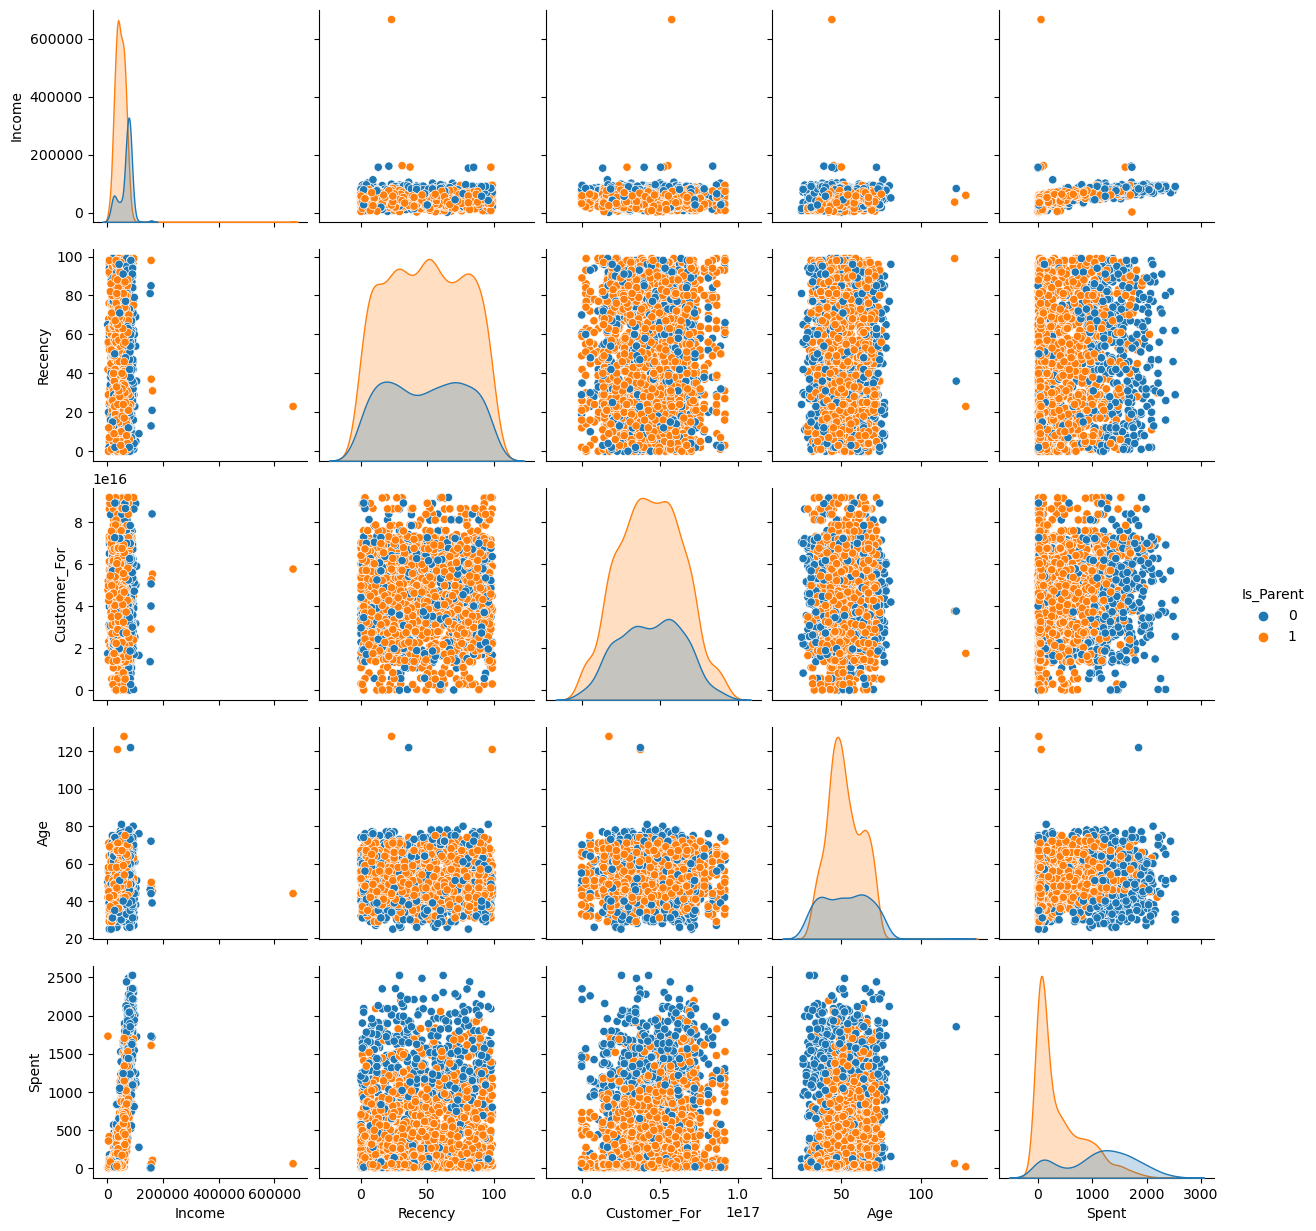

In [14]:
#To plot some selected features 

cat_var = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
sns.pairplot(data[cat_var], hue= "Is_Parent")

In [15]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print(f"The total number of data-points after removing the outliers are: {len(data)}")

The total number of data-points after removing the outliers are: 2212


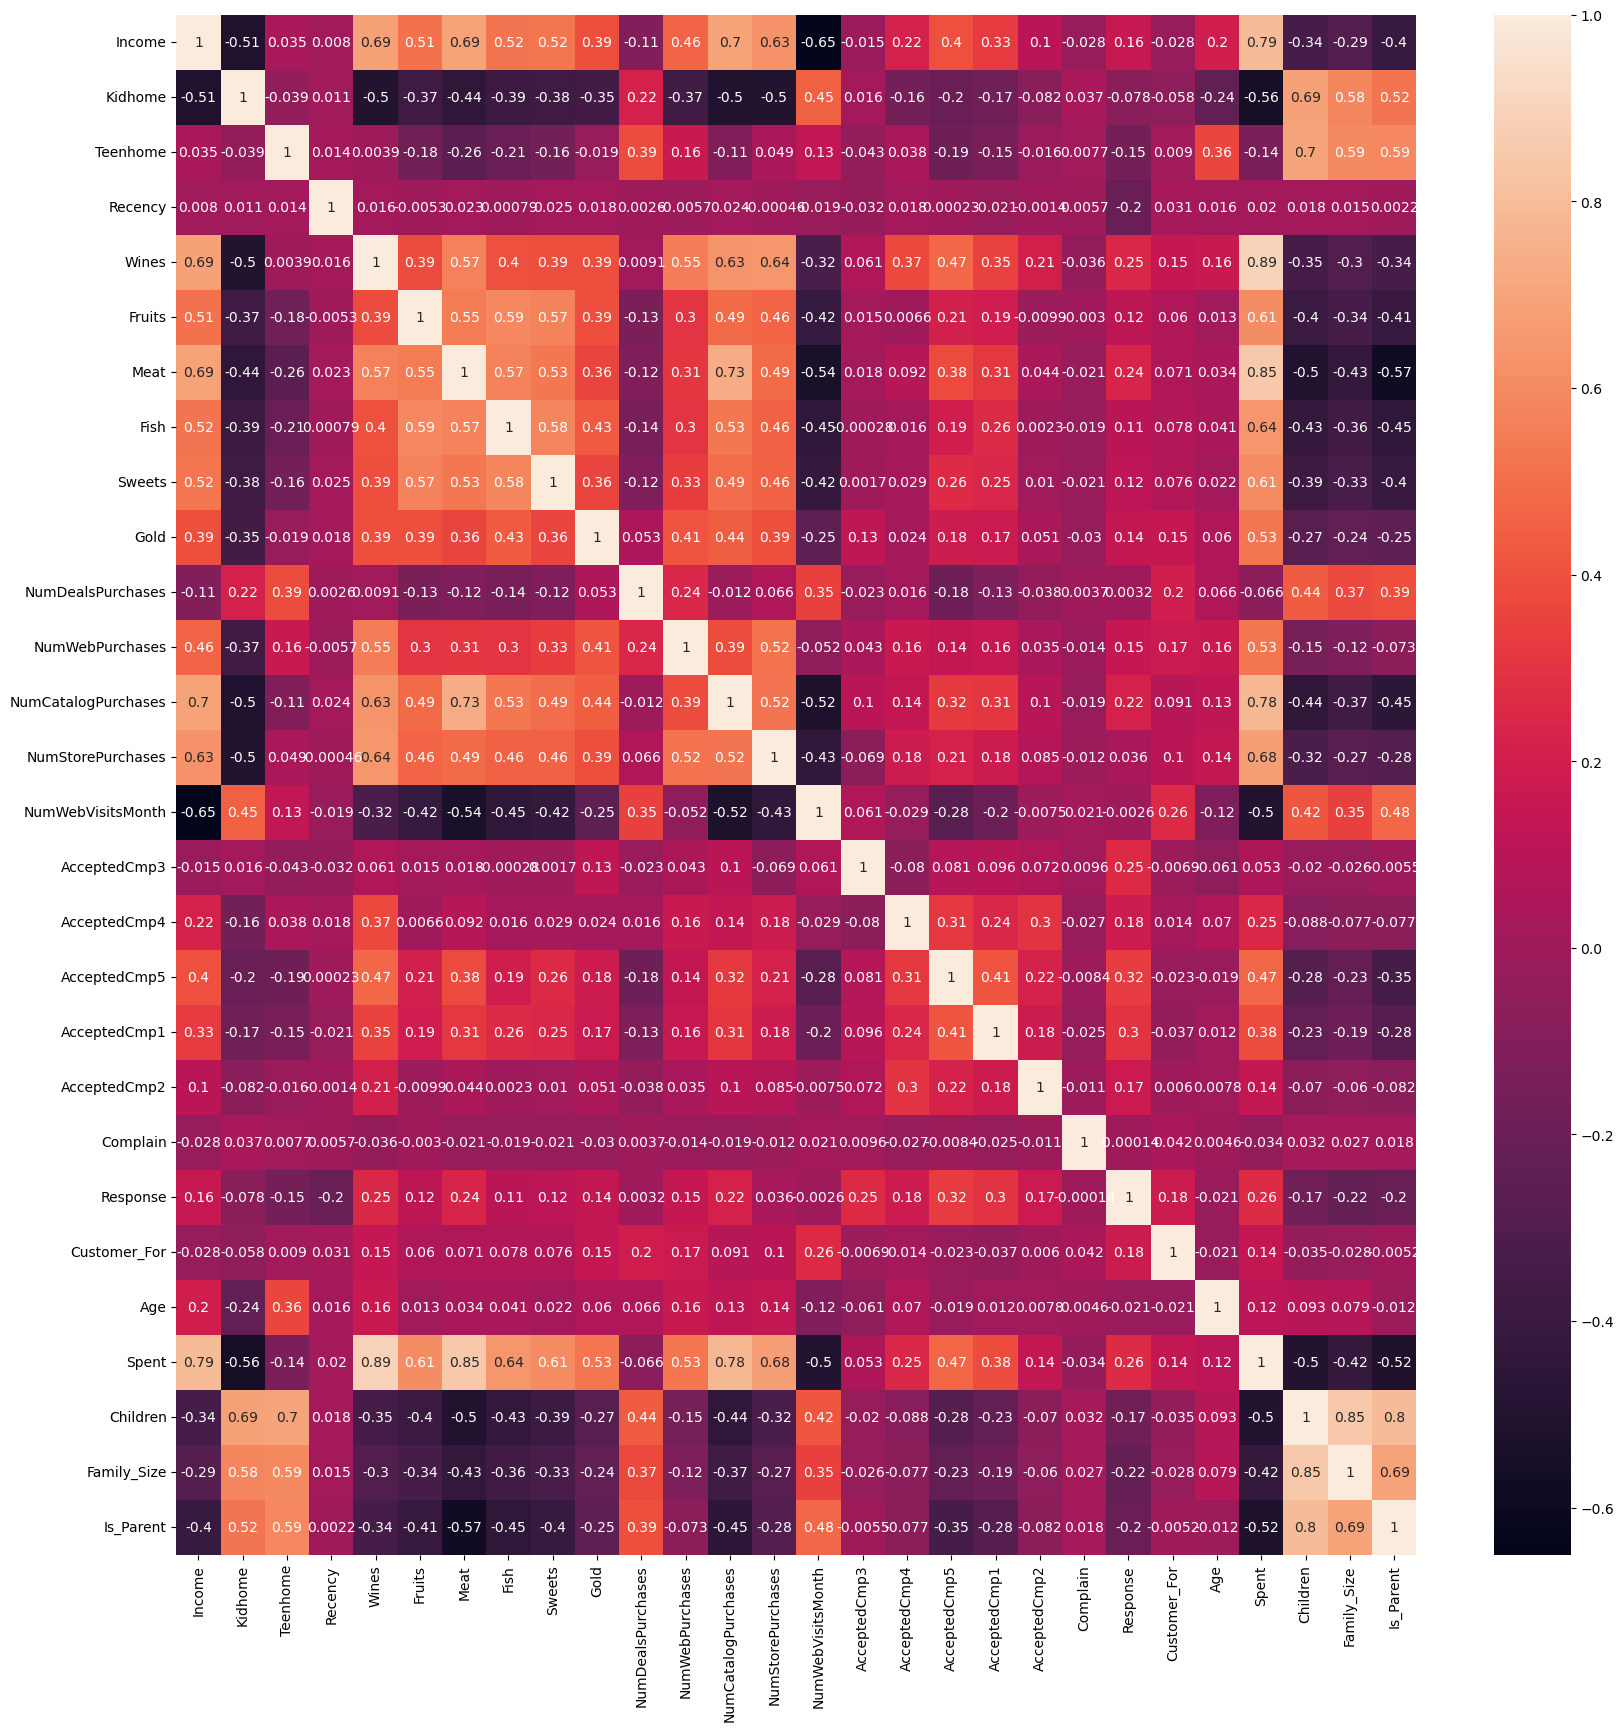

In [16]:
#correlation matrix
plt.figure(figsize=(20,20))  
sns.heatmap(data.corr(),annot=True);

## Unsupervised Machine Learning
**apply the principal component analysis (PCA) , its a technique for reducing dimension of large data set, increasing interpretability and same time minimizing information loss**
**steps 
- dimensionality reduction
- visualize/plot the new data set

In [17]:
data2 = data.copy()
cols_del = [ 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response' ]
data2 = data2.drop(cols_del,axis=1)

In [18]:
# importing from sklearn library
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

s = (data2.dtypes == "object")
cat_var = list(s[s].index)

#encode the category features
encoder = LabelEncoder()
for i in cat_var:
    data2[i] = data2[[i]].apply(encoder.fit_transform)

In [19]:
# scale the dataset
#from sklearn.preprocessing import MinMaxScaler
#scaler= MinMaxScaler()

scaler = StandardScaler()
scaled_data2 = pd.DataFrame(scaler.fit_transform(data2),columns = data2.columns)

In [20]:
scaled_data2.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [21]:
#instantiate PCA to reduce dimension
pca = PCA(n_components = 3)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_data2),columns=(["col1","col2","col3"]))
PCA_ds.head()

,col1,col2,col3
0,4.994345,-0.151184,2.649722
1,-2.884454,-0.006647,-1.863804
2,2.617864,-0.720693,-0.252425
3,-2.676036,-1.541956,-0.922045
4,-0.649595,0.209712,-0.021015


Text(0.5, 0.92, '3d visualization of the new dimension')

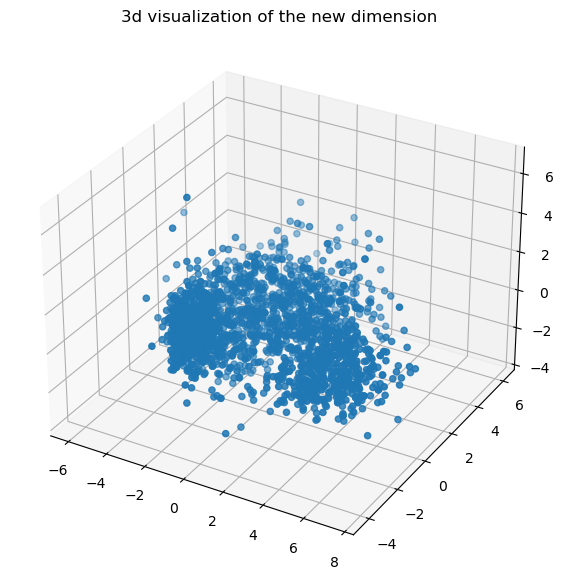

In [22]:
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]

fig = plt.figure(figsize =(10,7))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(x,y,z,marker="o")
ax.set_title("3d visualization of the new dimension")

In [23]:
pca.explained_variance_ratio_

array([0.36005684, 0.12660793, 0.064891  ])

### clustering
- elbow method to determine the number of clusters to be made
- clustering via k-means clustering
- examine our new clusters by plotting them out

In [24]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10))

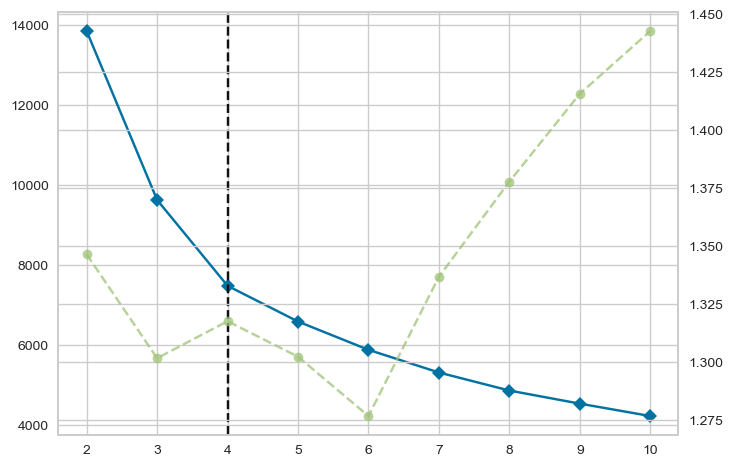

In [25]:
elbow_m = KElbowVisualizer(KMeans())
elbow_m.fit(PCA_ds)

In [26]:
# fit the kmeans algorithm to the dataset

kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
y_means = kmeans.fit_predict(PCA_ds)

#adding clusters to the dimension dataframe
PCA_ds["clusters"] = y_means
data["clusters"] = y_means


In [27]:
#PCA_ds
#data

Text(0.5, 0.92, '3d visualization of our data by their clusters')

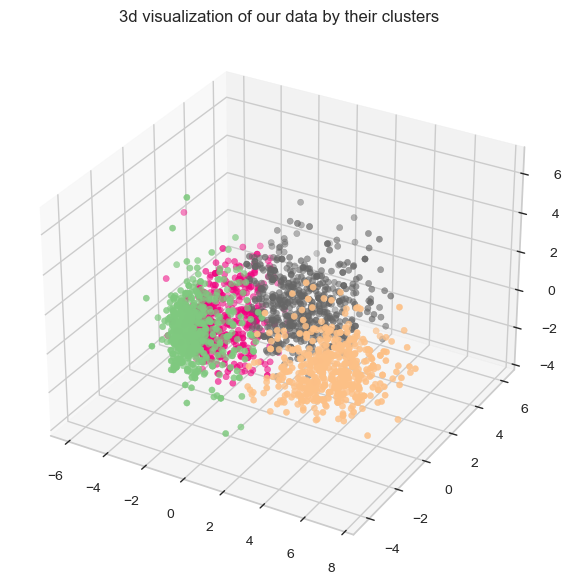

In [28]:
# plotting the new data point
cmap = "Accent"
fig = plt.figure(figsize =(10,7))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(x,y,z,c=data["clusters"],marker="o",cmap=cmap)
ax.set_title("3d visualization of our data by their clusters")

<Axes: xlabel='clusters', ylabel='count'>

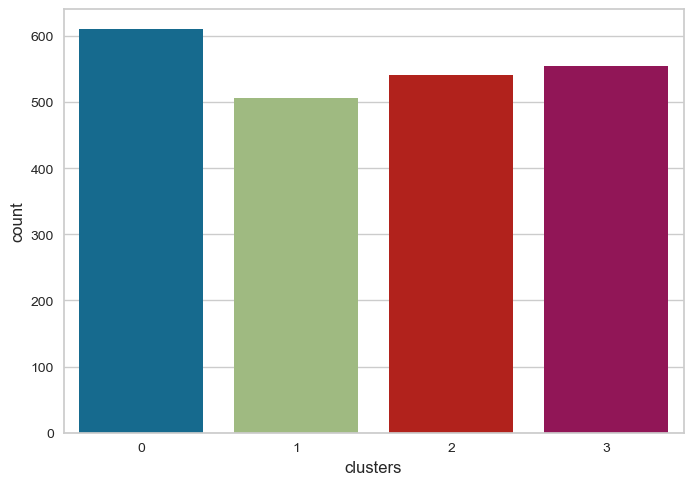

In [29]:
# distribution of clusters
sns.countplot(x=data['clusters'])

Text(0.5, 1.0, 'clusters profile base on spending and income power')

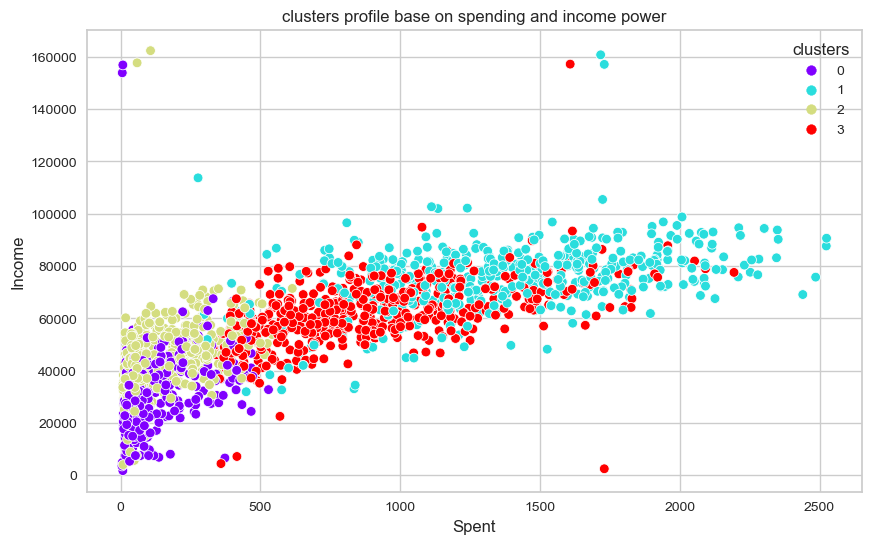

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data,x=data["Spent"], y=data["Income"], hue=data["clusters"],palette="rainbow")
plt.title("clusters profile base on spending and income power")

### observation
- cluster 1 are high earners and high spenders
- cluster 0 and cluster 2 are low earners and low spenders
- cluster 3 are average to high earners but average spenders